# Logistic Regression for abalone data set
### Analyzing Factors Influencing Abalone Age Classification

In [1]:
# 본 문서는 python 3.11.3 버전에서 작성되었습니다.

import pandas as pd
import numpy as np
import time
import warnings

# Plotting Libraries
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

# Model Libraries
from sklearn.model_selection import train_test_split, cross_val_score # train, test 데이터 분리 및 cross validation을 위한 패키지
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, roc_curve, auc, log_loss   # 모델 평가를 위한 패키지
from sklearn.preprocessing import StandardScaler, MinMaxScaler # 데이터 값 표준화 패키지
from sklearn.linear_model import LogisticRegression # Logistic Regression 모델

# Ignore warnings
warnings.filterwarnings('ignore')

In [2]:
# Importing the dataset
import os
os.chdir('/Users/nam0_k/Desktop/Git_repo/Machine-Learning/EDA/Abalone_data/') # Change the directory

In [3]:
# 데이터 프레임의 소수점 자리 수를 지정하는 함수
def round_dataframe(df, decimals=2):
    """
    DataFrame의 모든 float 열을 지정된 소수점 자리까지 반올림합니다.
    
    Args:
    df (pd.DataFrame): 반올림할 데이터프레임
    decimals (int): 반올림할 소수점 자리 수
    
    Returns:
    pd.DataFrame: 반올림된 데이터프레임
    """
    return df.applymap(lambda x: f"{x:.{decimals}f}" if isinstance(x, float) else x) # 소수점 자리수 지정

# 데이터프레임을 출력하는 함수
def format_df(df):
    """
    DataFrame을 테이블 형식으로 출력합니다.
    
    Args:
    df (pd.DataFrame): 출력할 데이터프레임
    
    Returns:
    str: 테이블 형식의 문자열
    """
    return tabulate(df, headers='keys', tablefmt='pretty')


## class2.csv
### 이중 분류에 대한 모델 및 분석

In [36]:
data = pd.read_csv("class2_basic.csv")
# data = pd.read_csv("class2_pca.csv", index_col=0)  ## PCA 데이터 사용시 주석 해제
data.head()

,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings,SexInfant
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,1,0
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,0,0
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,0,0
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,1,0
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,0,1


In [37]:
data.info()

# Rings의 Feature 이름 추출
col = data.drop("Rings", axis = 1)
feature_names = col.columns 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4170 entries, 0 to 4169
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Length          4170 non-null   float64
 1   Diameter        4170 non-null   float64
 2   Height          4170 non-null   float64
 3   Whole_weight    4170 non-null   float64
 4   Shucked_weight  4170 non-null   float64
 5   Viscera_weight  4170 non-null   float64
 6   Shell_weight    4170 non-null   float64
 7   Rings           4170 non-null   int64  
 8   SexInfant       4170 non-null   int64  
dtypes: float64(7), int64(2)
memory usage: 293.3 KB


In [38]:
feature = data.drop("Rings", axis = 1) # 열 기준으로 Rings 제거 후 Feature 변수에 저장
target = data["Rings"] # target 변수에 Rings 열 저장

X = feature.values # Numpy 배열로 변환
y = target.values

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0) # train set과 test set을 7:3 비율로 나눔

print("Size of training set: {} size of test set: {}\n".format(X_train.shape, X_test.shape))
# train set은 모델을 학습시키는데 사용되고, test set은 모델의 성능을 최종적으로 평가하는데 사용된다.

Size of training set: (3127, 8) size of test set: (1043, 8)



#### Data standardization

In [39]:
# scaler = MinMaxScaler() # MinMaxScaler 사용 시 주석 해제
scaler = StandardScaler() # StandardScaler 사용 시 주석 해제

scaler.fit(X_train) # train set에 대해 평균과 표준편차를 계산

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### Logistic Regression

#### 로지스틱 회귀 모델의 확률 추정
- $\hat p = h_\theta (\mathbf{x}) = \sigma(\mathbf{x}^T \beta) = \frac{1}{1 + e^{-\mathbf{x}^T \beta}}$

- 로지스틱 함수는 0과 1 사이의 값을 출력하는 시그모이드 함수
    - $\sigma(t) = \frac{1}{1 + e^{-t}}$
- 역함수는 자연스레 로그오즈비가 된다.  
    - $\log\left(\frac{\hat{p}}{1-\hat{p}}\right) = \mathbf{x}^T \beta$

#### 로지스틱 회귀 모델 예측
- $\hat y = \begin{cases} 0 & \text{if } \hat{p} < 0.5 \\ 1 & \text{if } \hat{p} \geq 0.5 \end{cases}$

    - 로지스틱 회귀모델은 $\mathbf{x}^T \beta$ 가 양수 일 때, 1이라고 예측
    -  $\mathbf{x}^T \beta$ 가 음수 일 때, 0이라고 예측


#### 로지스틱 회귀 모델의 비용 함수
- 하나의 훈련 샘플에 대한 비용 함수

- $c(\beta) = \begin{cases} -log(\hat{p}) & \text{if } y = 1 \\-log(1 - \hat{p}) & \text{if } y = 0 \end{cases}$

    - $t$가 0 에 가까워질 떄, 다시 말해 $\mathbf{x}^T \beta$가 0에 가까워 질 때, $-log(t)$가 매우 커지므로 타당
    - 즉, 모델의 양성 샘플이 0에 가까운 확률을 추정하면 비용이 크게 증가할 것임
    - 음성 샘플이 1에 가까운 확률을 추정해도 비용이 크게 증가할 것

##### Log-loss function
- $\text{Log-Loss} = -\frac{1}{N} \sum_{i=1}^{N} \left[ y_i \log(p_i) + (1 - y_i) \log(1 - p_i) \right]$
- 전체 훈련 세트에 대한 비용함수의 평균임 
- 이 손실의 최소화되는 점이 최대 가능도가 가장 높은 모델이라는 수학적 타당성이 보장되어 있다.


In [40]:
# 로지스틱 회귀 모델 학습 및 평가


start_time = time.time() # 시작 시간 저장

best_score = 0 # best_score 변수 초기화
# 여러 C 값에 대한 성능 테스트
for C in [0.001, 0.01, 0.1, 1, 10, 100]:
    logreg = LogisticRegression(C=C)
    scores = cross_val_score(logreg, X_train_scaled, y_train, cv=5) # 5-fold cross validation 수행
    score = np.mean(scores) # 5-fold cross validation score의 평균 계산
    
    if score > best_score: # best_score보다 높은 경우
        best_score = score
        best_parameters = {"C": C} # best_parameters 업데이트

# 여러 C 값에 대한 성능 테스트
logreg = LogisticRegression(**best_parameters) 
logreg.fit(X_train_scaled, y_train)

# 학습 세트와 테스트 세트에서의 성능 평가
train_score = logreg.score(X_train_scaled, y_train)
test_score = logreg.score(X_test_scaled, y_test)


end_time = time.time() # 종료 시간 저장



# Error Rate 계산
train_error_rate = 1 - train_score
test_error_rate = 1 - test_score

# 예측값 생성
y_pred = logreg.predict(X_test_scaled) # 예측값
y_prob = logreg.predict_proba(X_test_scaled)[:, 1] # 1로 예측될 확률

# Classification Report
class_report = classification_report(y_test, y_pred)

# ROC Curve 및 AUC 계산
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Log-Loss 계산
log_loss_value = log_loss(y_test, y_prob)

# 회귀 계수 추출
coefficients = logreg.coef_[0]


# 결과 데이터 생성
results = {
    "Metric": ["Best parameters", 
               "Cross validation score", "Training set score", "Test set score", 
               "Training error rate", "Test error rate", "Execution time"],
    "Value": [str(best_parameters), 
              best_score, train_score, test_score, 
              train_error_rate, test_error_rate, end_time - start_time]
}
results_df = pd.DataFrame(results)

# 각 열을 소수점 둘째 자리까지 반올림
results_df = round_dataframe(results_df)

# 결과를 테이블 형식으로 출력
print("Results:\n")
print(format_df(results_df))

Results:

+---+------------------------+----------+
|   |         Metric         |  Value   |
+---+------------------------+----------+
| 0 |    Best parameters     | {'C': 1} |
| 1 | Cross validation score |   0.79   |
| 2 |   Training set score   |   0.79   |
| 3 |     Test set score     |   0.78   |
| 4 |  Training error rate   |   0.21   |
| 5 |    Test error rate     |   0.22   |
| 6 |     Execution time     |   0.41   |
+---+------------------------+----------+


1. 정밀도
- $Precision = \frac{TP}{TP + FP}$

- 진짜 양성의 분류 / 진짜 양성 + 거짓 양성

- Confusion matrix에서 [2, 2] / [2, 2] + [2, 1]

- 정밀도를 100%로 만들고 싶다면, 확실한 예측만 양성으로 판단한다면 가능하다. 하지만, 재현율이 떨어질 것이다.

- Support = TP + FP | TN + FN


2. 재현율
- $Recall = \frac{TP}{TP +FN}$

- 진짜 양성의 분류 / 진짜 양성 + 거짓 음성

- Confusion matrix에서 [2, 2] / [2, 2] + [1, 2]

- 정밀도와 재현율은 같이 보아야 한다.

3. F1 점수
$$ F_\beta = \frac{(1 + \beta^2) \cdot \text{Precision} \cdot \text{Recall}}{(\beta^2 \cdot \text{Precision}) + \text{Recall}} $$
- 	$\beta = 1$인 경우 : F_1 score
- 	$\beta > 1$인 경우 : Recall에 더 큰 가중치
- 	$\beta < 1$인 경우 : Precision에 더 큰 가중치


$$F_1 = \frac{2 \cdot \text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}$$
- 정밀도와 재현율의 조화 평균식

- $F_1$ 점수가 높아지려면 정밀도와 재현율 모두 높아져야 함.

- 정밀도와 재현율은 Trade off 관계에 있음

- 상황에 따라, 어린 아이에게 나쁜 동영상 걸러내는 경우는 정밀도가 높아야 할 것이며

- 도둑이 드는 경우를 체크할 때는, 재현율이 높아야 할 것임(경비원이 잘못된 출동을 하겠지만)


4. ROC AUC
- 거짓 양성 비율(FPR)에 대한 진짜 양성 비율 (TPR = Recall) 의 곡선 $ROC = \frac{TPR}{FPR}$
- $$FPR = \frac{FP}{FP + TN} = \frac{FP + TN - TN}{FP + TN} = 1 - \frac{TN}{FP + TN} = 1 - TNR$$
    - 전체인 1에서 음성으로 정확하게 분류한 음성 샘플의 비율인 진짜 음성 비율 (TNR)을 뺀 값이 FPR이다.
    - AUC 는 ROC 커브 아래의 면적을 의미함 완벽한 분류기의 AUC는 1이고, 완전 Random한 분류기의 경우 0.5이다. 
    - 좋은 분류기의 경우 AUC 면적이 넓어짐.

5. Log-loss
- $\text{Log-Loss} = -\frac{1}{N} \sum_{i=1}^{N} \left[ y_i \log(p_i) + (1 - y_i) \log(1 - p_i) \right]$
    - 전체 훈련 세트에 대한 비용함수의 평균

6. Coefficients
- 로지스틱 분류기의 회귀 모델의 확률 추정 $\hat{p} = h_\theta (\mathbf{x}) = \sigma(\mathbf{x}^T \beta)$
    - Sigmoid function $\sigma(t) = \frac{1}{1 + e^{-t}}$

- 회귀계수는 따라서 $\log\left(\frac{\hat{p}}{1-\hat{p}}\right) = \beta_0 x_0 + \beta_1 x_1 + \beta_2 x_2 + \ldots + \beta_7 x_7$에 대한 $\beta$값의 추정
- (로지스틱 함수에 대한 역함수가 로짓함수. 따라서 역함수를 취해주면, 우리가 익히 알고 있는, 선형회귀의 수식이 나옴)


In [41]:
# Classification Report 출력
class_report_dict = classification_report(y_test, y_pred, output_dict=True) # output_dict=True : 딕셔너리 형태로 출력
class_report_df = pd.DataFrame(class_report_dict).transpose()

# 'accuracy' 행의 'support' 값을 제거
class_report_df.loc['accuracy', 'support'] = ''


# ROC AUC와 Log-Loss 값을 포함한 데이터프레임 생성
results = {
    "Metric": ["ROC AUC", "Log-Loss"],
    "Value": [roc_auc, log_loss_value]
}
results_df = pd.DataFrame(results)

# 계수를 포함한 데이터프레임 생성
coefficients_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coefficients
})

# float 열을 소수점 둘째 자리까지 반올림
class_report_df = round_dataframe(class_report_df)
results_df = round_dataframe(results_df)
coefficients_df = round_dataframe(coefficients_df)

print("Classification Report:\n")
print(format_df(class_report_df))


Classification Report:

+--------------+-----------+--------+----------+---------+
|              | precision | recall | f1-score | support |
+--------------+-----------+--------+----------+---------+
|      0       |   0.78    |  0.81  |   0.79   | 532.00  |
|      1       |   0.79    |  0.76  |   0.78   | 511.00  |
|   accuracy   |   0.78    |  0.78  |   0.78   |         |
|  macro avg   |   0.78    |  0.78  |   0.78   | 1043.00 |
| weighted avg |   0.78    |  0.78  |   0.78   | 1043.00 |
+--------------+-----------+--------+----------+---------+


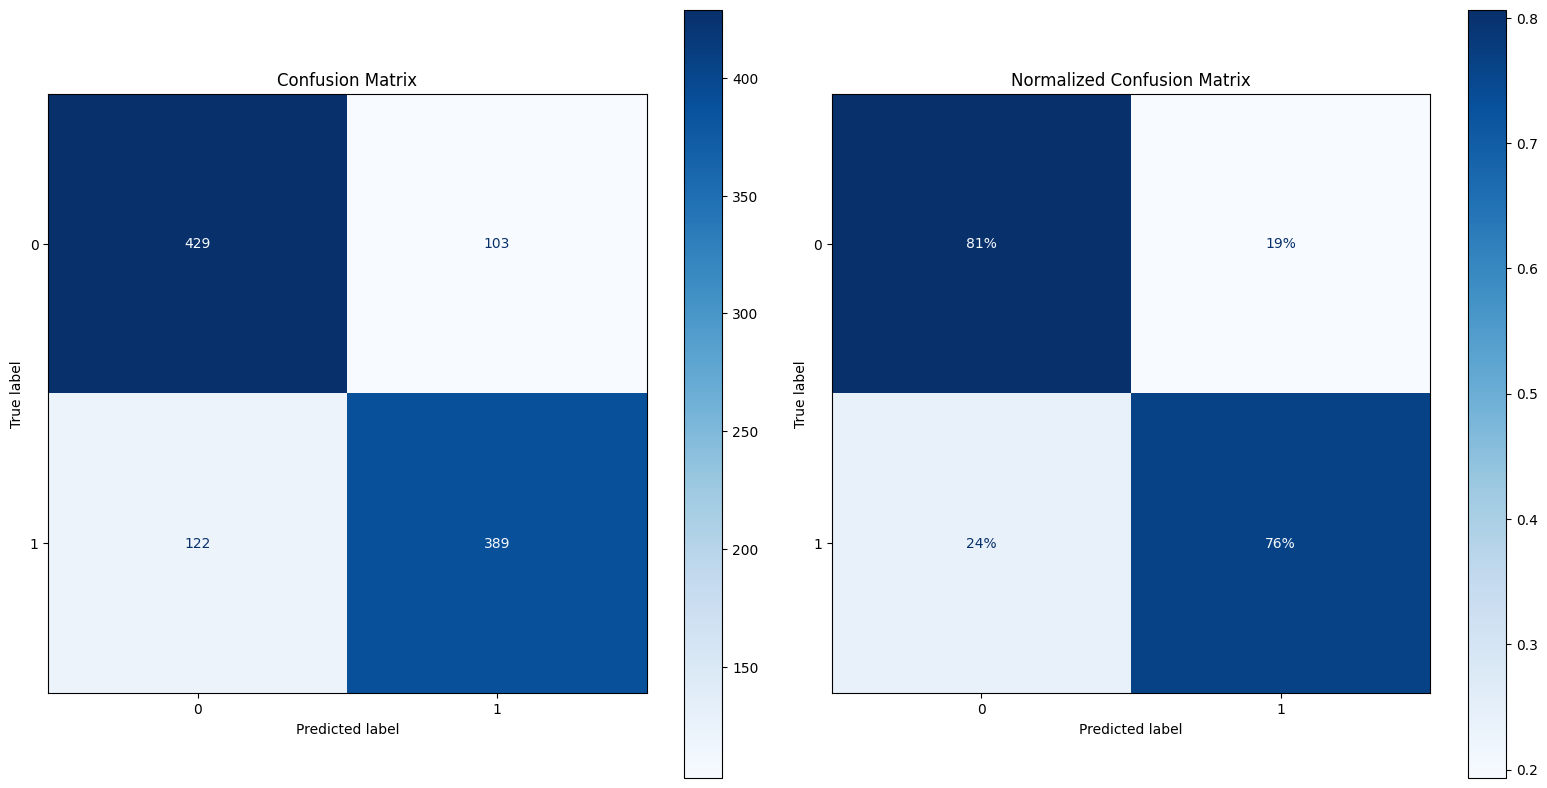

In [42]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

# Confusion Matrix 계산 및 시각화
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax[0], cmap='Blues')
ax[0].set_title('Confusion Matrix')

# Normalized Confusion Matrix 계산 및 시각화
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='true', ax=ax[1], values_format=".0%", cmap='Blues')
ax[1].set_title('Normalized Confusion Matrix')

plt.tight_layout()
plt.show()


ROC AUC and Log-Loss:

+---+----------+-------+
|   |  Metric  | Value |
+---+----------+-------+
| 0 | ROC AUC  | 0.87  |
| 1 | Log-Loss | 0.45  |
+---+----------+-------+


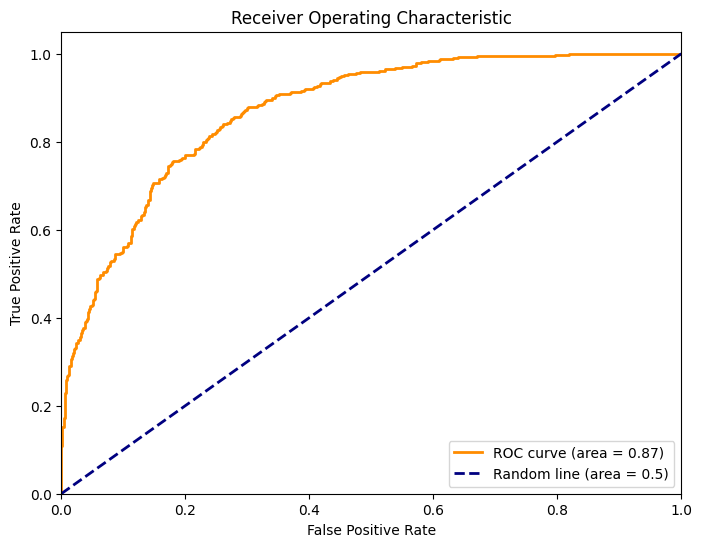

In [43]:
print("\nROC AUC and Log-Loss:\n")
print(format_df(results_df))

# ROC Curve 시각화
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random line (area = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


Coefficients:

+---+----------------+-------------+
|   |    Feature     | Coefficient |
+---+----------------+-------------+
| 0 |     Length     |    -0.36    |
| 1 |    Diameter    |    0.28     |
| 2 |     Height     |    0.47     |
| 3 |  Whole_weight  |    2.48     |
| 4 | Shucked_weight |    -2.82    |
| 5 | Viscera_weight |    -0.08    |
| 6 |  Shell_weight  |    1.62     |
| 7 |   SexInfant    |    -0.41    |
+---+----------------+-------------+


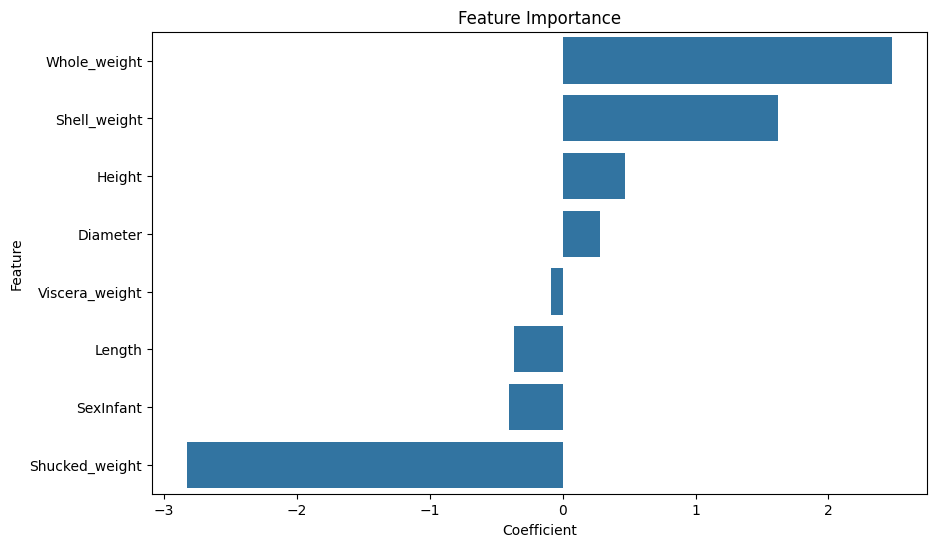

In [44]:
print("\nCoefficients:\n")
print(format_df(coefficients_df))

# 특성 중요도 (계수) 플롯

plt.figure(figsize=(10, 6))
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
coef_df = coef_df.sort_values(by='Coefficient', ascending=False) # ascending=False : 내림차순 정렬
sns.barplot(x='Coefficient', y='Feature', data=coef_df)
plt.title('Feature Importance')
plt.show()

## class3.csv
### 다중 분류에 대한 모델 및 분석

In [45]:
data = pd.read_csv("class3_basic.csv")
# data = pd.read_csv("class3_pca.csv", index_col=0) ## PCA 적용한 데이터 사용시 주석 해제
data.head()

,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings,SexInfant
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,2,0
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,1,0
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,1,0
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,1,0
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,1,1


In [46]:
feature = data.drop("Rings", axis = 1)
target = data["Rings"]

X = feature.values
y = target.values

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

print("Size of training set: {} size of test set: {}\n".format(X_train.shape, X_test.shape))

Size of training set: (3127, 8) size of test set: (1043, 8)



In [47]:
# scaler = MinMaxScaler()
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 로지스틱 회귀 모델 학습 및 평가

start_time = time.time()

best_score = 0
for C in [0.001, 0.01, 0.1, 1, 10, 100]:
    logreg = LogisticRegression(C=C, multi_class='multinomial', max_iter=1000) ## iteration 횟수 지정 Error에 대한 Feedback
    scores = cross_val_score(logreg, X_train_scaled, y_train, cv=5)
    score = np.mean(scores)
    
    if score > best_score:
        best_score = score
        best_parameters = {"C": C}


# 최적의 하이퍼파라미터 C 값과 Multinomial 로 모델 학습
logreg = LogisticRegression(**best_parameters, multi_class='multinomial', max_iter=1000)
logreg.fit(X_train_scaled, y_train)

train_score = logreg.score(X_train_scaled, y_train)
test_score = logreg.score(X_test_scaled, y_test)

end_time = time.time()


train_error_rate = 1 - train_score
test_error_rate = 1 - test_score

y_pred = logreg.predict(X_test_scaled)
y_prob = logreg.predict_proba(X_test_scaled)


# Classification Report
class_report = classification_report(y_test, y_pred)

# 결과 데이터 생성
results = {
    "Metric": ["Best parameters", 
               "Cross validation score", "Training set score", "Test set score", 
               "Training error rate", "Test error rate", "Execution time"],
    "Value": [str(best_parameters), 
              best_score, train_score, test_score, 
              train_error_rate, test_error_rate, end_time - start_time]
}
results_df = pd.DataFrame(results)

# 각 열을 소수점 둘째 자리까지 반올림
results_df = round_dataframe(results_df)

# 결과를 테이블 형식으로 출력
print("Results:\n")
print(format_df(results_df))

Results:

+---+------------------------+----------+
|   |         Metric         |  Value   |
+---+------------------------+----------+
| 0 |    Best parameters     | {'C': 1} |
| 1 | Cross validation score |   0.84   |
| 2 |   Training set score   |   0.84   |
| 3 |     Test set score     |   0.86   |
| 4 |  Training error rate   |   0.16   |
| 5 |    Test error rate     |   0.14   |
| 6 |     Execution time     |   0.70   |
+---+------------------------+----------+


In [48]:
# Classification Report 출력
class_report_dict = classification_report(y_test, y_pred, output_dict=True) # output_dict=True : 딕셔너리 형태로 출력
class_report_df = pd.DataFrame(class_report_dict).transpose()

# 'accuracy' 행의 'support' 값을 제거
class_report_df.loc['accuracy', 'support'] = ''

# float 열을 소수점 둘째 자리까지 반올림
class_report_df = round_dataframe(class_report_df)


print("Classification Report:\n")
print(format_df(class_report_df))

Classification Report:

+--------------+-----------+--------+----------+---------+
|              | precision | recall | f1-score | support |
+--------------+-----------+--------+----------+---------+
|      0       |   0.79    |  0.50  |   0.61   |  54.00  |
|      1       |   0.87    |  0.96  |   0.91   | 840.00  |
|      2       |   0.69    |  0.40  |   0.50   | 149.00  |
|   accuracy   |   0.86    |  0.86  |   0.86   |         |
|  macro avg   |   0.78    |  0.62  |   0.68   | 1043.00 |
| weighted avg |   0.84    |  0.86  |   0.84   | 1043.00 |
+--------------+-----------+--------+----------+---------+


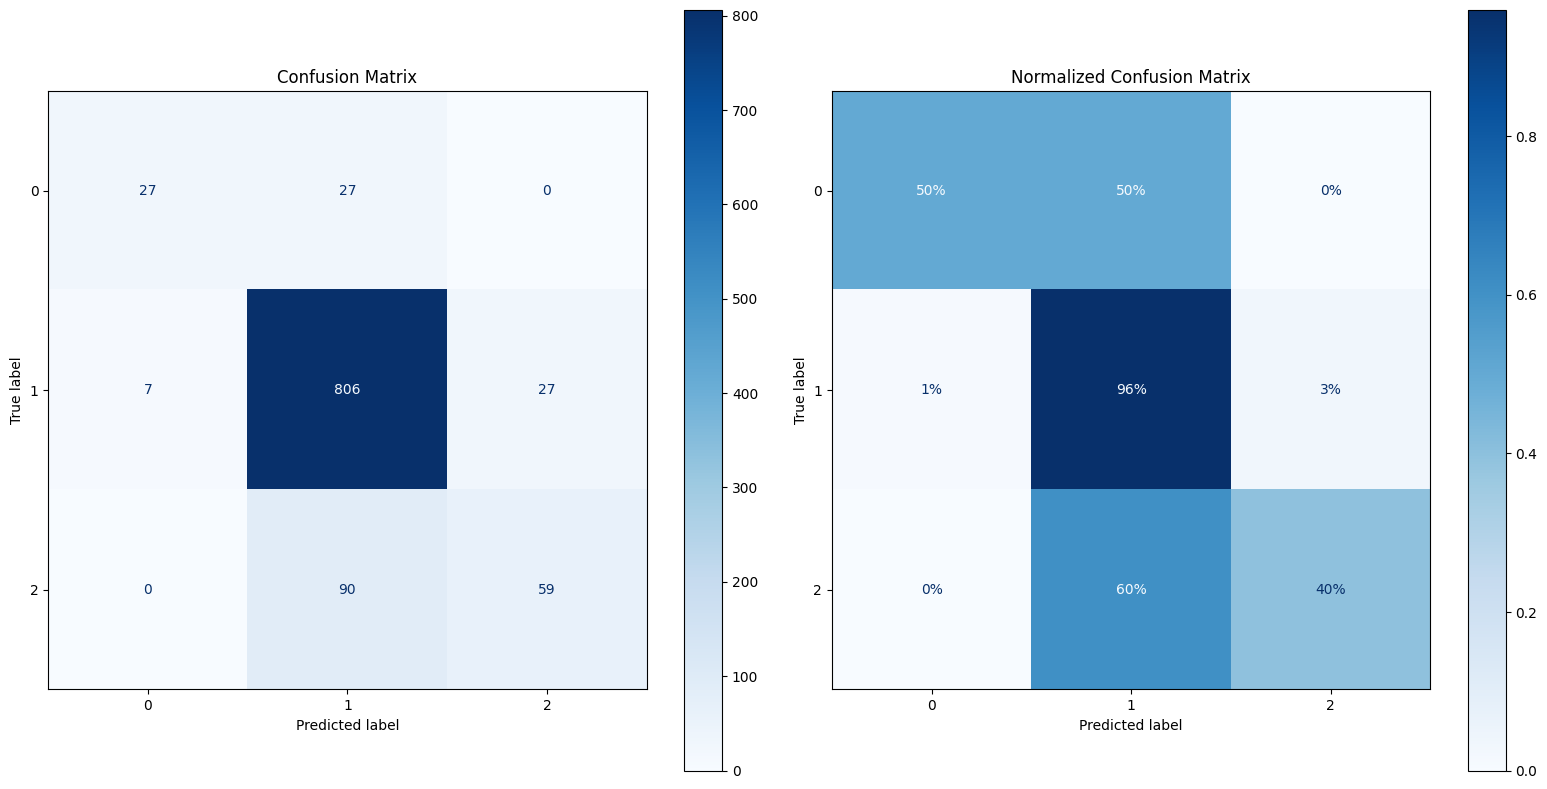

In [49]:
# 혼동 행렬 플롯
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

# 혼동 행렬 계산 및 시각화
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax[0], cmap='Blues')
ax[0].set_title('Confusion Matrix')

# 정규화된 혼동 행렬 계산 및 시각화
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='true', ax=ax[1], values_format=".0%", cmap='Blues')
ax[1].set_title('Normalized Confusion Matrix')

plt.tight_layout()
plt.show()